### О проекте

#### Название проекта

Система автоматического анализа общественных настроений на основе новостных публикаций и социальных сообщений.

#### Какую задачу решает продукт

Продукт решает задачу автоматизации анализа медиапространства, он позволяет быстро и объективно оценивать общественные настроения по большим массивам текстов (новостей, постов, комментариев), выявлять тренды и изменения восприятия определённых тем или событий.

Тем самым он помогает организациям и частным лицам сократить время аналитики, уменьшить ручные затраты и повысить точность мониторинга общественного мнения.

### Библиотеки

In [1]:
import pandas as pd
import numpy as np

import mlflow
import mlflow.pytorch
import mlflow.sklearn
from mlflow.models.signature import infer_signature

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

import fasttext

import torch
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers.integrations import MLflowCallback

import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### Загрузку и очистка данных

Основной обучающий датасет для baseline-решения – [**sentiment-analysis-in-russian**](https://www.kaggle.com/competitions/sentiment-analysis-in-russian)

#### Загрузка данных sentiment-analysis-in-russian

In [2]:
dataset_train = pd.read_json('/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/data/sentiment-analysis-in-russian/train.json')

dataset_train.shape

(8263, 3)

#### Проверка дублей

In [3]:
# по id

dataset_train['id'].duplicated().sum()

np.int64(0)

In [4]:
# по text

dataset_train['text'].duplicated().sum()

np.int64(314)

In [5]:
# Посмотреть на дубли + лейблы

mask = dataset_train.duplicated(subset = 'text', keep=False)
dataset_train[mask].sort_values(by='text').head()

,text,id,sentiment
5976,\n \nВ конце года банки повысили кредитную акт...,8030,neutral
5173,\n \nВ конце года банки повысили кредитную акт...,7227,positive
6548,"\n""Городом-героем"", сдавшим больше всего автом...",8602,neutral
5290,"\n""Городом-героем"", сдавшим больше всего автом...",7344,positive
7096,\n«Самоочищение системы» напоминает подвиг бар...,9150,neutral


In [6]:
dataset_train[mask].groupby('text')['sentiment'].nunique().min()

np.int64(2)

In [7]:
# Проверка текста

# print(dataset_train.iloc[5976]['text'])

# print(dataset_train.iloc[5173]['text'])

Обнаружил конфликтующие наблюдения: один и тот же текст имел разные оценки сентимента. Принял решение полностью удалить такие случаи. Дополнительно прогнал выборку через LLM для проверки качества разметки – есть отдельные замечания, но в целом все нормально.

In [8]:
# Удаление спорных объектов

dataset_train_adj = dataset_train.drop(index=dataset_train[mask].index).copy()

In [9]:
# Повторная проверка

dataset_train_adj['text'].duplicated().sum()

np.int64(0)

In [10]:
dataset_train_adj.shape[0], dataset_train.shape[0]

(7635, 8263)

#### Проверка NaN

In [11]:
dataset_train_adj.isnull().sum()

text         0
id           0
sentiment    0
dtype: int64

#### Проверка на аномалии

In [12]:
dataset_train_adj.value_counts(subset = 'sentiment', normalize=True)

sentiment
neutral     0.488147
positive    0.336346
negative    0.175508
Name: proportion, dtype: float64

In [13]:
dataset_train_adj['text'].str.split().str.len().describe()

count     7635.000000
mean       490.631172
std       1171.542560
min          4.000000
25%        162.000000
50%        265.000000
75%        464.000000
max      48146.000000
Name: text, dtype: float64

Есть крайние значения которые сильно выбиваются из распределения, лучше провалидировать их руками

In [14]:
dataset_train_adj['text_len'] = dataset_train_adj['text'].str.split().str.len()

In [15]:
dataset_train_adj.sort_values(by='text_len').iloc[2]

text         По сообщению сайта Матрица.kz\n
id                                      8579
sentiment                           positive
text_len                                   4
Name: 6525, dtype: object

In [16]:
dataset_train_adj.sort_values(by='text_len').iloc[4]

text         \nАлматы\nПо сообщению сайта Banker.kz\n
id                                               5676
sentiment                                    negative
text_len                                            5
Name: 3622, dtype: object

In [17]:
dataset_train_adj.sort_values(by='text_len').iloc[6]

text         Извините но эта ссылка не доступна\n
id                                           3429
sentiment                                 neutral
text_len                                        6
Name: 1375, dtype: object

In [18]:
# Удаляю хвосты

lower = dataset_train_adj['text_len'].quantile(0.01)
upper = dataset_train_adj['text_len'].quantile(0.99)

dataset_train_adj = dataset_train_adj[(dataset_train_adj['text_len'] > lower) & (dataset_train_adj['text_len'] < upper)].copy()

In [19]:
dataset_train_adj.shape

(7479, 4)

Данные не совсем чистые, но, кажется, для baseline-решения это некритично. На текущем этапе я исключил очевидные выбросы, а далее планирую обогатить датасет данными из `MonoHime/ru_sentiment_dataset`.

#### Приведение текста к стандартному виду

In [20]:
dataset_train_adj['text'] = dataset_train_adj['text'].str.strip().str.lower()

In [21]:
dataset_train_adj.head()

,text,id,sentiment,text_len
0,досудебное расследование по факту покупки енпф...,1945,negative,166
1,медики рассказали о состоянии пострадавшего му...,1957,negative,202
2,"прошел почти год, как железнодорожным оператор...",1969,negative,1139
3,по итогам 12 месяцев 2016 года на территории р...,1973,negative,511
5,об аресте бывшего министра национальной эконом...,1980,negative,212


#### Кодирование классов

In [22]:
label_map = {"negative":0, "neutral":1, "positive":2}
dataset_train_adj["label"] = dataset_train_adj["sentiment"].map(label_map)

In [23]:
dataset_train_adj.value_counts(subset = ['sentiment', 'label'], normalize=True)

sentiment  label
neutral    1        0.487899
positive   2        0.337077
negative   0        0.175023
Name: proportion, dtype: float64

In [24]:
dataset_train_adj.head()

,text,id,sentiment,text_len,label
0,досудебное расследование по факту покупки енпф...,1945,negative,166,0
1,медики рассказали о состоянии пострадавшего му...,1957,negative,202,0
2,"прошел почти год, как железнодорожным оператор...",1969,negative,1139,0
3,по итогам 12 месяцев 2016 года на территории р...,1973,negative,511,0
5,об аресте бывшего министра национальной эконом...,1980,negative,212,0


#### Очистка текста

In [25]:
def clean_text(t):
    t = re.sub(r'http\S+', '', t)
    t = re.sub(r'[^\w\s!?.,-]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

dataset_train_adj['text'] = dataset_train_adj['text'].apply(clean_text)

In [26]:
dataset_train_adj.head()

,text,id,sentiment,text_len,label
0,досудебное расследование по факту покупки енпф...,1945,negative,166,0
1,медики рассказали о состоянии пострадавшего му...,1957,negative,202,0
2,"прошел почти год, как железнодорожным оператор...",1969,negative,1139,0
3,по итогам 12 месяцев 2016 года на территории р...,1973,negative,511,0
5,об аресте бывшего министра национальной эконом...,1980,negative,212,0


In [27]:
# Еще раз посмотрим на дубли

dataset_train_adj['text'].duplicated().sum()

np.int64(19)

In [28]:
mask_2 = dataset_train_adj.duplicated(subset = 'text', keep=False)
dataset_train_adj[mask_2].sort_values(by='text').head()

,text,id,sentiment,text_len,label
7224,"29 декабря 2016 года, алматы казкоммерцбанк об...",9278,positive,817,2
1221,"29 декабря 2016 года, алматы казкоммерцбанк об...",3275,positive,817,2
2469,в 2016 году банки предпочитали инвестировать в...,4523,positive,948,2
7727,в 2016 году банки предпочитали инвестировать в...,9781,neutral,948,1
4870,"в енпф сажают, а пенсии выпалывают? т.ибраев т...",6924,negative,2239,0


In [29]:
# Консистентность лейблов у дублей

df_temp = dataset_train_adj[mask_2].groupby('text')['sentiment'].nunique()

df_temp.value_counts()

sentiment
1    15
2     4
Name: count, dtype: int64

In [30]:
# Удаление объектов где лейблы не консистентны

lst_drop = df_temp[df_temp > 1].index.tolist()

dataset_train_adj = dataset_train_adj[~dataset_train_adj['text'].isin(lst_drop)]

In [31]:
dataset_train_adj.drop_duplicates(subset = 'text', inplace = True)

In [32]:
dataset_train_adj.duplicated(subset = 'text').sum()

np.int64(0)

In [33]:
# Очищенный датасет

dataset = dataset_train_adj[['text', 'sentiment', 'label']].copy()

### Анализ данных

#### Общая информация о датасете

In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7456 entries, 0 to 8262
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       7456 non-null   object
 1   sentiment  7456 non-null   object
 2   label      7456 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 233.0+ KB


In [35]:
dataset.describe(include='all')

,text,sentiment,label
count,7456,7456,7456.000000
unique,7456,3,NaN
top,досудебное расследование по факту покупки енпф...,neutral,NaN
freq,1,3637,NaN
mean,NaN,NaN,1.162420
std,NaN,NaN,0.697058
min,NaN,NaN,0.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,2.000000


- Всего 7456 наблюдений
- Наиболее частотный класс – **neutral**
- Дублей и пропусков – нет

#### Распределение классов

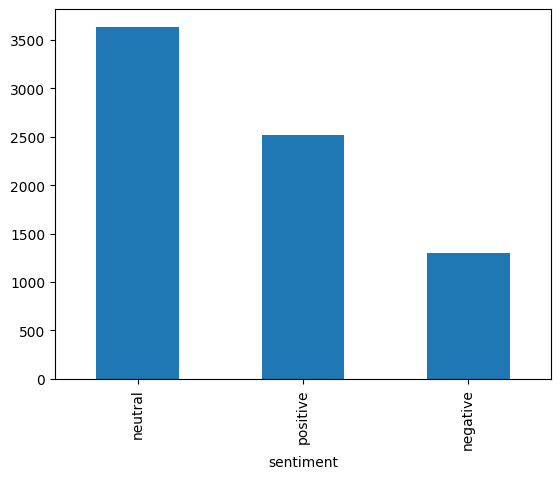

In [36]:
dataset['sentiment'].value_counts().plot(kind='bar')

plt.show()

- В качестве основной метрики качества модели буду использовать Macro F1-score.

**Причины выбора:**

- классы тональности распределены неравномерно (нейтральных больше всего);
- важно оценивать качество предсказаний для каждого класса, включая редкие (негатив);
- Macro F1 равноправно учитывает вклад всех классов.

#### Анализ длины текстов

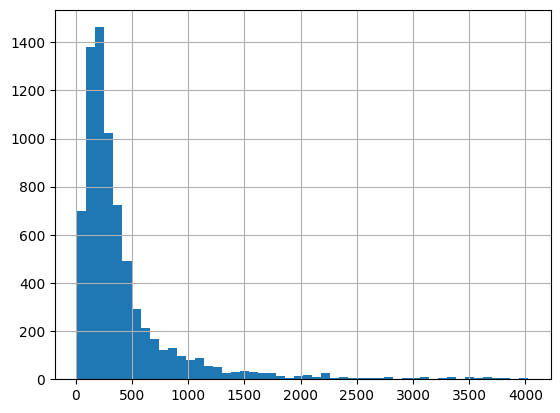

In [37]:
dataset['text_len'] = dataset['text'].str.split().str.len()
dataset['text_len'].hist(bins=50)

plt.show()

In [38]:
dataset['text_len'].describe()

count    7456.000000
mean      426.664968
std       511.758748
min        15.000000
25%       166.000000
50%       268.000000
75%       461.000000
max      4026.000000
Name: text_len, dtype: float64

- Данные неоднородные, с небольшим кол-вом длинных текстов;
- 75% текстов относительно короткие (до 461)

Выбор простой и усложненной моделей:
- **TF-IDF + LogReg:** Хорошо работает на коротких и средних текстах (до 500 слов), но не чувствует порядка слов и есть вероятность столкнуться с OOV
- **fastText + LogReg:** Не чувствительна к длине, OOV не ломает модель
- **RuBERT:** Дает лучшее качество почти во всех задачах, но сложнее в обучении

Кажется оптимальной стратегией использовать fastText + LogReg как простую модель и RuBERT как усложненною.

#### Примеры текстов по каждому классу

In [66]:
for label in dataset['sentiment'].unique():
    print(f"\n### {label.upper()}\n")
    print(dataset[dataset['sentiment']==label].sample(1)['text'].tolist())


### NEGATIVE

['информация о хакерской атаке появилась на странице центра анализа и расследования кибератак царка в facebook. царка сообщил о массовом взломе сайтов местных государственных органов в северо-казахстанской области, государственных и бюджетных учреждений восточно-казахстанской, алматинской областей, других организаций департамент природных ресурсов вко, сайт маслихата г. алматы, казгипроводхоз , казахский драматический театр и другие . основной причиной стало, что владельцы пренебрегли мерами безопасности, а также использовали устаревшие и нелицензионные версий cms. также царка привел список взломанных ресурсов, среди них политехнический колледж г. атырау , институт казгипроводхоз г. алматы , медиахолдинг кызылжар-акпарат акимата ско г. петропавловск , ао казахэнергоэкспертиза г. астана , ао астана-теплотранзит г. астана , управление экономики и бюджетного планирования г. талыдкорган , нпо ассоциация налогоплательщиков и бухгалтеров г. караганда , корпоративный фонд подде

Эмпирически, примеры тональности (негатив, позитив, нейтрально) адекватно классифицируют новостные тексты

#### Частотность слов по классам

In [40]:
for label in dataset['sentiment'].unique():
    words = [i for i in ' '.join(dataset[dataset['sentiment']==label]['text']).split() if len(i) > 3 and i.lower()]
    print(label, Counter(words).most_common(5))

negative [('года', 1817), ('енпф', 1281), ('2016', 1218), ('также', 1115), ('тенге', 1077)]
positive [('года', 3723), ('также', 2645), ('2016', 2524), ('году', 2052), ('казахстана', 1890)]
neutral [('года', 6568), ('также', 4039), ('году', 3479), ('тенге', 3479), ('будет', 3385)]


Топ частотных слов по классам показывает, что частотная лексика не различает тональность, и модель должна ориентироваться на контекст, редкие слова или сочетания слов, чтобы корректно классифицировать новости.

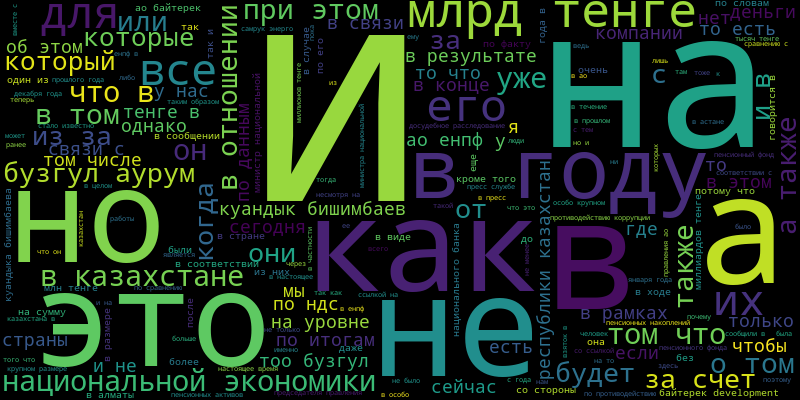

In [41]:
# Визуализация облака слов по классу "negative"

text = ' '.join(dataset.query('sentiment == "negative"')['text'])
WordCloud(width=800, height=400).generate(text).to_image()

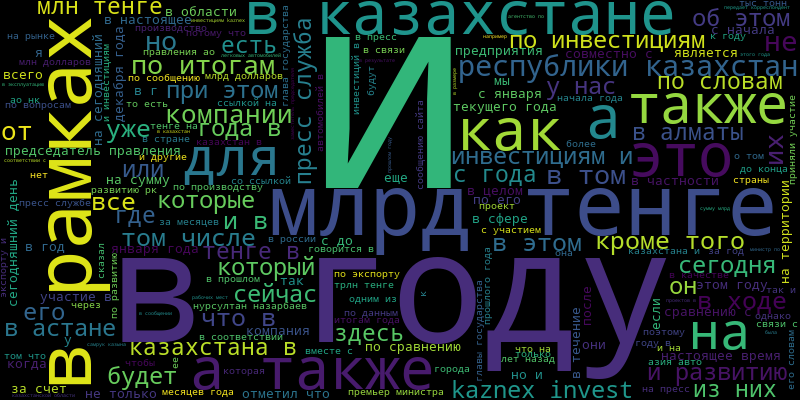

In [42]:
# Визуализация облака слов по классу "positive"

text = ' '.join(dataset.query('sentiment == "positive"')['text'])
WordCloud(width=800, height=400).generate(text).to_image()

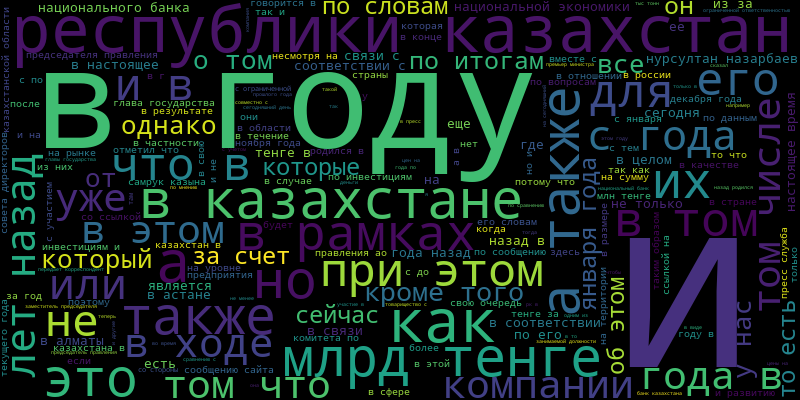

In [43]:
# Визуализация облака слов по классу "neutral"

text = ' '.join(dataset.query('sentiment == "neutral"')['text'])
WordCloud(width=800, height=400).generate(text).to_image()

#### Резюме

- Датасет содержит 7456 примеров;
- Классы распределены не равномерно;
- Тексты средние (median length ~ 268 слов), что важно учитывать при выборе модели;
- В датасете отсутствуют типичные маркеры эмоциональности;
- Нейтральные тексты более фактологические, что соответствует будущему применению на новостях;
- Очистка была выполнена корректно: дубликаты удалены, пропусков нет.
- Датасет подходит для обучения baseline и BERT-моделей.

### TF-IDF + Logistic Regression 

#### Разделить данные

С сохранением пропорций классов

In [44]:
train, test = train_test_split(dataset, test_size=0.15, stratify=dataset['label'], random_state=42)
train, val  = train_test_split(train, test_size=0.15, stratify=train['label'], random_state=42)

In [45]:
train.shape, val.shape, test.shape

((5386, 4), (951, 4), (1119, 4))

#### Параметры

In [46]:
tfidf_params = {
    "max_features": 50000,
    "ngram_range": (1, 2),
    "min_df": 3
}

logreg_params = {
    "C": 1.0,
    "max_iter": 500,
    "class_weight": "balanced",
    "solver": "lbfgs"
}

**TF-IDF**

- `max_features = 50 000` — ограничивает размер словаря, снижая память/время, но оставляя достаточно признаков для выразительности модели;
- `ngram_range = (1, 2)` — учитываются униграммы и биграммы, что позволяет ловить устойчивые фразы и контекст;
- `min_df = 3` — отбрасывает слишком редкие слова, уменьшая шум и переобучение;

**Logistic Regression**

- `C = 1.0` — баланс между переобучением и недообучением;
- `max_iter = 500` — достаточно итераций, чтобы гарантировать сходимость на больших разреженных TF-IDF матрицах;
- `class_weight = "balanced"` — компенсирует дисбаланс классов, повышая устойчивость модели;
- `solver = "lbfgs"` — быстрый и стабильный оптимизатор для многомерных задач с L2-регуляризацией.

#### Pipeline

In [47]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=tfidf_params["max_features"],
        ngram_range=tfidf_params["ngram_range"],
        min_df=tfidf_params["min_df"]
    )),
    ("logreg", LogisticRegression(
        C=logreg_params["C"],
        max_iter=logreg_params["max_iter"],
        class_weight=logreg_params["class_weight"],
        solver=logreg_params["solver"],
        n_jobs=-1
    ))
])

#### MLFlow RUN

In [48]:
# Настройка MLflow

mlflow.set_tracking_uri("http://127.0.0.1:5050")
mlflow.set_experiment("baseline-sentiment-modeling")

2025/11/23 22:07:50 INFO mlflow.tracking.fluent: Experiment with name 'baseline-sentiment-modeling' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1763924870153, experiment_id='1', last_update_time=1763924870153, lifecycle_stage='active', name='baseline-sentiment-modeling', tags={}>

Validation F1-macro: 0.7298
Validation Accuracy: 0.7392

Test F1-macro: 0.7493
Test Accuracy: 0.7560

Совокупная метрика (Test): 0.7527



Successfully registered model 'tfidf_logreg_baseline'.
2025/11/23 22:08:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tfidf_logreg_baseline, version 1


🏃 View run tfidf_logreg_baseline at: http://127.0.0.1:5050/#/experiments/1/runs/fd09bc9162e1449d840eaf1e8e8bef8b
🧪 View experiment at: http://127.0.0.1:5050/#/experiments/1
MLflow run completed!


Created version '1' of model 'tfidf_logreg_baseline'.


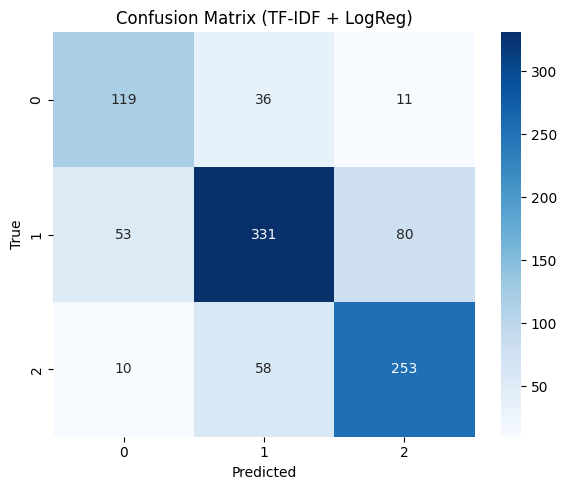

In [49]:
model_name = "tfidf_logreg_baseline"

with mlflow.start_run(run_name=model_name):

    # логирование параметров
    mlflow.log_params({
        "tfidf_max_features": tfidf_params["max_features"],
        "tfidf_ngram_range": tfidf_params["ngram_range"],
        "tfidf_min_df": tfidf_params["min_df"],
        "logreg_C": logreg_params["C"],
        "logreg_max_iter": logreg_params["max_iter"],
        "logreg_class_weight": logreg_params["class_weight"],
        "logreg_solver": logreg_params["solver"],
        "train_size": len(train),
        "val_size": len(val),
        "test_size": len(test),
        "dataset_name": "Sentiment Analysis in Russian",
        "random_state": 42
    })

    # обучение модели
    pipeline.fit(train["text"], train["label"])

    # валидация
    y_val_pred = pipeline.predict(val["text"])

    f1_macro = f1_score(val["label"], y_val_pred, average="macro")
    acc = accuracy_score(val["label"], y_val_pred)

    mlflow.log_metric("val_f1_macro", f1_macro)
    mlflow.log_metric("val_accuracy", acc)

    print(f"Validation F1-macro: {f1_macro:.4f}")
    print(f"Validation Accuracy: {acc:.4f}", end='\n\n')

    # тест
    y_test_pred = pipeline.predict(test["text"])

    f1_macro = f1_score(test["label"], y_test_pred, average="macro")
    acc = accuracy_score(test["label"], y_test_pred)

    mlflow.log_metric("test_f1_macro", f1_macro)
    mlflow.log_metric("test_accuracy", acc)

    print(f"Test F1-macro: {f1_macro:.4f}")
    print(f"Test Accuracy: {acc:.4f}", end='\n\n')

    print(f"Совокупная метрика (Test): {(f1_macro + acc) / 2:.4f}", end='\n\n')

    # артефакт отчета классификации
    report_text = classification_report(val["label"], y_val_pred)
    with open("classification_report.txt", "w") as f:
        f.write(report_text)
    mlflow.log_artifact("classification_report.txt")

    # артефакт матрицы ошибок
    cm = confusion_matrix(val["label"], y_val_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (TF-IDF + LogReg)")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")

    mlflow.log_artifact("confusion_matrix.png")

    # артефакт ошибок
    errors = val.copy()
    errors["pred"] = y_val_pred
    errors = errors[errors["pred"] != errors["label"]]
    errors.head(30).to_csv("sample_errors.csv", index=False)

    mlflow.log_artifact("sample_errors.csv")

    # сохранение модели
    signature = infer_signature(train["text"], pipeline.predict(train["text"]))
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        name="model",
        registered_model_name=model_name,
        signature=signature
    )

print("MLflow run completed!")

#### Резюме (анализ результатов)

- Значения ~0.73–0.75 – хороший уровень для простых моделей текстовой классификации;
  
- Accuracy немного выше F1-macro из-за наличия более частого доминирующего класса (нейтрально);
  
- Качество на тесте выше, чем на валидации это признаки того, что переобучения нет, модель хорошо обобщает;
  
- Чаще всего модель путает позитив/негатив с нейтрально (0), модель не улавливает глубокий контекст, только частоты слов;
  
- Совокупная метрика демонстрирует стабильное качество около 0.75, что подтверждает устойчивость модели.

### fastText + Logistic Regression 

#### Загрузка предобученной модели fastText

In [51]:
fasttext_model_path = "/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/fasttext/cc.ru.300.bin"

ft = fasttext.load_model(fasttext_model_path)
embedding_dim = ft.get_word_vector("привет").shape[0]

embedding_dim

300

#### Векторизация

In [52]:
def ft_vectorize(text: str, model: fasttext.FastText._FastText, dim: int = 300) -> np.ndarray:
    """
    Превращает текст в вектор: усреднение эмбеддингов слов.
    Если токенов нет – возвращает вектор нулей.
    """
    words = text.split()
    if not words:
        return np.zeros(dim, dtype=np.float32)
    vecs = [model.get_word_vector(w) for w in words]
    return np.mean(vecs, axis=0)


def build_matrix(df, model, dim=300):
    return np.vstack(df["text"].apply(lambda t: ft_vectorize(t, model, dim)))

In [53]:
X_train_ft = build_matrix(train, ft, embedding_dim)
X_val_ft   = build_matrix(val, ft, embedding_dim)
X_test_ft  = build_matrix(test, ft, embedding_dim)

y_train = train["label"].values
y_val   = val["label"].values
y_test  = test["label"].values

In [54]:
X_train_ft[0][:5]

array([ 0.00756574, -0.00815981,  0.00464205, -0.00868456, -0.00660307],
      dtype=float32)

In [55]:
y_train[:5]

array([2, 2, 1, 1, 1])

#### MLflow RUN

Validation F1-macro: 0.5376
Validation Accuracy: 0.5436

Test F1-macro: 0.5549
Test Accuracy: 0.5612

Совокупная метрика (Test): 0.5581



Successfully registered model 'fasttext_logreg_baseline'.
2025/11/23 22:08:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: fasttext_logreg_baseline, version 1


🏃 View run fasttext_logreg_baseline at: http://127.0.0.1:5050/#/experiments/1/runs/e69949775a624a869dfebf1e9902ffa3
🧪 View experiment at: http://127.0.0.1:5050/#/experiments/1
MLflow run completed.


Created version '1' of model 'fasttext_logreg_baseline'.


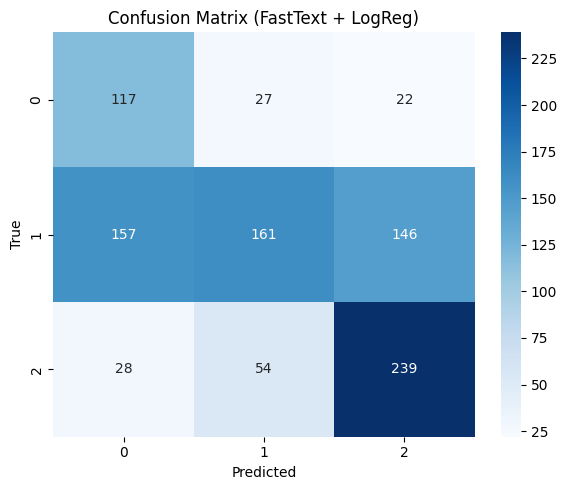

In [56]:
model_name = "fasttext_logreg_baseline"

with mlflow.start_run(run_name=model_name):

    # логирование параметров
    mlflow.log_params({
        "fasttext_model_path": fasttext_model_path,
        "fasttext_embedding_dim": embedding_dim,
        "logreg_C": logreg_params["C"],
        "logreg_max_iter": logreg_params["max_iter"],
        "logreg_class_weight": logreg_params["class_weight"],
        "logreg_solver": logreg_params["solver"],
        "train_size": len(train),
        "val_size": len(val),
        "test_size": len(test),
        "dataset_name": "Sentiment Analysis in Russian",
        "random_state": 42
    })

    # обучение модели
    logreg = LogisticRegression(
        C=logreg_params["C"],
        max_iter=logreg_params["max_iter"],
        class_weight=logreg_params["class_weight"],
        solver=logreg_params["solver"],
        n_jobs=-1
    )

    logreg.fit(X_train_ft, y_train)

    # валидация
    y_val_pred = logreg.predict(X_val_ft)

    f1_macro = f1_score(y_val, y_val_pred, average="macro")
    acc = accuracy_score(y_val, y_val_pred)

    mlflow.log_metric("val_f1_macro", f1_macro)
    mlflow.log_metric("val_accuracy", acc)

    print(f"Validation F1-macro: {f1_macro:.4f}")
    print(f"Validation Accuracy: {acc:.4f}", end='\n\n')

    # тест
    y_test_pred = logreg.predict(X_test_ft)

    f1_macro = f1_score(y_test, y_test_pred, average="macro")
    acc = accuracy_score(y_test, y_test_pred)

    mlflow.log_metric("test_f1_macro", f1_macro)
    mlflow.log_metric("test_accuracy", acc)

    print(f"Test F1-macro: {f1_macro:.4f}")
    print(f"Test Accuracy: {acc:.4f}", end='\n\n')

    print(f"Совокупная метрика (Test): {(f1_macro + acc) / 2:.4f}", end='\n\n')

    # артефакт отчета классификации
    report_text = classification_report(y_val, y_val_pred)
    with open("classification_report_ft.txt", "w") as f:
        f.write(report_text)

    mlflow.log_artifact("classification_report_ft.txt")

    # артефакт матрицы ошибок
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (FastText + LogReg)")
    plt.tight_layout()
    plt.savefig("confusion_matrix_ft.png")

    mlflow.log_artifact("confusion_matrix_ft.png")

    # артефакт ошибок
    errors = val.copy()
    errors["pred"] = y_val_pred
    errors = errors[errors["pred"] != errors["label"]]
    errors.head(30).to_csv("sample_errors_ft.csv", index=False)

    mlflow.log_artifact("sample_errors_ft.csv")

    # сохранение модели
    # В MLflow сохраняем только LogisticRegression;
    # для инференса нужно будет повторить шаг построения матрицы через fastText. (писать кастомный sklearn-совместимый класс на данном этапе не решился)
    signature = infer_signature(X_train_ft, logreg.predict(X_train_ft))
    mlflow.sklearn.log_model(
        sk_model=logreg,
        name="model",
        registered_model_name=model_name,
        signature=signature
    )

print("MLflow run completed.")

#### Резюме (анализ результатов)

- Значения F1-macro 0.54–0.56 — заметно ниже, чем у TF-IDF + LogReg (0.73–0.75). FastText-вектора в текущей реализации хуже отделяют классы;
  
- Качество на тесте выше, чем на валидации, что означает отсутствие переобучения – модель обобщает стабильно, но уровень обобщения сам по себе низкий (сравнительно с TF-IDF);
  
- Из матрицы ошибок видно, что модель значительно сильнее путает классы, особенно класс 1 (нейтрально);

- В отличие от TF-IDF-модели, FastText-вектора не дали улучшения контекстной информативности: модель запуталась сильнее, чем при работе с TF-IDF.

- Совокупная метрика для теста (0.56) значительно ниже совокупной метрики TF-IDF-модели (0.75), что говорит о её существенно худшем качестве. Несмотря на стабильность результатов, качество остаётся недостаточным по сравнению с предыдущей моделью.

### RuBERT

#### Параметры

In [57]:
model_name = "cointegrated/rubert-tiny2"
num_labels = 3                            
max_length = 512
batch_size = 32
num_epochs = 5
learning_rate = 2e-5
weight_decay = 0.01
seed = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [58]:
training_args = TrainingArguments(
    output_dir="./rubert_sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=seed,
    dataloader_pin_memory=False
)

#### Подготовка данных

In [59]:
# Конвертируем pandas в HF Dataset
train_ds = Dataset.from_pandas(train.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test.reset_index(drop=True))

tokenizer = AutoTokenizer.from_pretrained(model_name, add_chat_template=False)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )

train_ds = train_ds.map(tokenize_batch, batched=True, batch_size=512)
val_ds   = val_ds.map(tokenize_batch, batched=True, batch_size=512)
test_ds  = test_ds.map(tokenize_batch, batched=True, batch_size=512)

Map:   0%|          | 0/5386 [00:00<?, ? examples/s]

Map:   0%|          | 0/951 [00:00<?, ? examples/s]

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

In [60]:
# Удаляем лишние колонки и переименовываем label
cols_to_remove = [c for c in train_ds.column_names if c not in ("input_ids", "attention_mask", "label")]
train_ds = train_ds.remove_columns(cols_to_remove)
val_ds   = val_ds.remove_columns(cols_to_remove)
test_ds  = test_ds.remove_columns(cols_to_remove)

train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

train_ds.set_format(type="torch")
val_ds.set_format(type="torch")
test_ds.set_format(type="torch")

#### Модель

In [61]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Метрики

In [62]:
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "f1_macro": f1_macro
    }

#### MLflow RUN

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.905500,0.842102,0.607781,0.486874
2,0.776800,0.760040,0.667718,0.648821
3,0.704100,0.735370,0.665615,0.646105
4,0.651300,0.724285,0.659306,0.644973
5,0.654400,0.721191,0.667718,0.652967


Validation metrics: {'eval_loss': 0.7211907505989075, 'eval_accuracy': 0.6677181913774973, 'eval_f1_macro': 0.6529672184423535, 'eval_runtime': 5.2109, 'eval_samples_per_second': 182.5, 'eval_steps_per_second': 5.757, 'epoch': 5.0}
Test Accuracy: 0.6899
Test F1-macro: 0.6756
Совокупная метрика (Test): 0.6828



Python(24669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/11/23 22:18:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run cointegrated/rubert-tiny2 at: http://127.0.0.1:5050/#/experiments/1/runs/f7dbb6e59cf94e629e145756f5e4c3d3
🧪 View experiment at: http://127.0.0.1:5050/#/experiments/1
MLflow run completed.


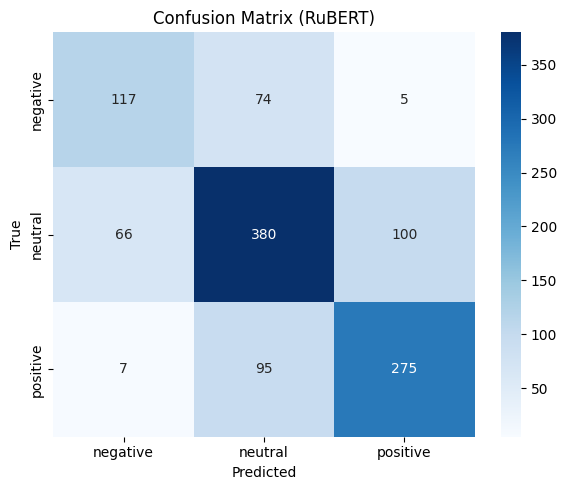

In [63]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

with mlflow.start_run(run_name=model_name):

    # логирование параметров
    mlflow.log_params({
        "model_name": model_name,
        "num_labels": num_labels,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "seed": seed,
        "train_size": len(train_ds),
        "val_size": len(val_ds),
        "test_size": len(test_ds),
        "dataset_name": "Sentiment Analysis in Russian"
    })

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    # обучение
    trainer.train()

    # валидация
    val_metrics = trainer.evaluate(eval_dataset=val_ds)
    mlflow.log_metrics({f"val_{k}": v for k, v in val_metrics.items()})
    print("Validation metrics:", val_metrics)

    # оценка
    test_outputs = trainer.predict(test_ds)
    test_logits = test_outputs.predictions
    test_labels = test_outputs.label_ids
    test_preds = np.argmax(test_logits, axis=-1)

    test_acc = accuracy_score(test_labels, test_preds)
    test_f1_macro = f1_score(test_labels, test_preds, average="macro")

    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_f1_macro", test_f1_macro)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-macro: {test_f1_macro:.4f}")

    print(f"Совокупная метрика (Test): {(test_f1_macro + test_acc) / 2:.4f}", end='\n\n')

    # артефакт отчета классификации
    report = classification_report(
        test_labels,
        test_preds,
        target_names=[id2label[i] for i in range(num_labels)]
    )
    with open("classification_report_rubert.txt", "w") as f:
        f.write(report)

    mlflow.log_artifact("classification_report_rubert.txt")

    # артефакт матрицы ошибок
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[id2label[i] for i in range(num_labels)],
                yticklabels=[id2label[i] for i in range(num_labels)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (RuBERT)")
    plt.tight_layout()
    plt.savefig("confusion_matrix_rubert.png")

    mlflow.log_artifact("confusion_matrix_rubert.png")

    # ошибки
    test_texts = test.reset_index(drop=True)
    errors_mask = test_preds != test_labels
    errors = test_texts[errors_mask].copy()
    errors["true_label"] = [id2label[int(l)] for l in test_labels[errors_mask]]
    errors["pred_label"] = [id2label[int(p)] for p in test_preds[errors_mask]]
    errors.head(50).to_csv("sample_errors_rubert.csv", index=False)

    mlflow.log_artifact("sample_errors_rubert.csv")

    # сохранение модели
    mlflow.pytorch.log_model(
        pytorch_model=trainer.model,
        name="rubert_model"
    )

print("MLflow run completed.")

#### Резюме (анализ результатов)

- Значения F1-macro 0.65–0.67 на валидации и тесте – модель заметно лучше, чем FastText + LogReg (0.55), но всё же уступает TF-IDF + LogReg (0.75). Модель RuBERT уверенно превосходит классические эмбеддинги, но в текущей конфигурации не достигает качества лучшей из простых моделей;

- Accuracy немного выше F1-macro (0.67–0.69), что указывает на всё тот же перекос класса нейтрально, однако RuBERT справляется с этим перекосом лучше, чем FastText, и почти догоняет TF-IDF;

- Качество на тесте выше, чем на валидации (F1-macro 0.6756 против 0.6529) это признаки того, что переобучения нет, и модель хорошо обобщает. Стабильность метрик по эпохам также подтверждает корректную настройку обучения;

- По матрице ошибок видно, что RuBERT точнее различает позитив и негатив, чем обе предыдущие модели. Большинство ошибок связаны с тем, что нейтральный класс остаётся смежным по смыслу и частично перекрывается с негативным и позитивным контекстами;

- Модель почти не путает негатив с позитив напрямую (5 случаев), это прямое улучшение за счёт понимания контекста;

- Совокупная метрика на тесте (0.68) выше, чем у FastText (0.56), но ниже TF-IDF (0.75), что показывает промежуточный уровень качества: модель обучается эффективно, но её компактная архитектура (rubert-tiny2) ограничивает максимальную точность.